# Configurazione di Fabry Perot


0.005257222598682364 0.0002676819121582499 16615.134904670864 845.9925405877523
0.005334694698063584 0.0002787693984694521 16859.9267631072 881.0310486613929
0.00518978627257394 0.00024255715601397476 16402.213598965827 766.5969443039796
0.005259969875834479 0.0002641562197412738 16623.890355251526 834.8534605198737
0.005259969875834479 0.0002641562197412738 16623.890355251526 834.8534605198737
0.005329556516524443 0.00027435630748091043 16843.750211883413 867.0869928679037


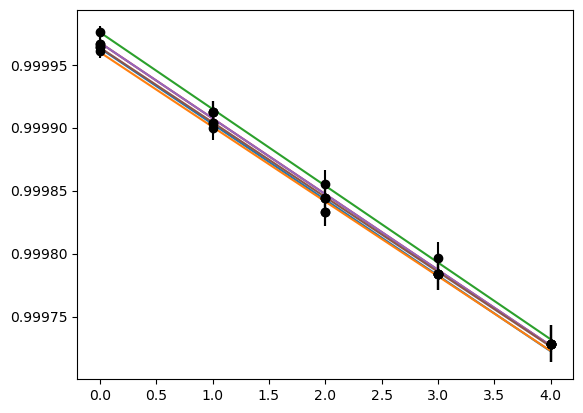

In [35]:
import pandas as pd
import numpy as np

_lambda = 632.8 * 10**(-9)

dati = pd.read_excel("Interferometro.xlsx")

# distanze in metri
#display(dati)
L_focale = 18 * 10**(-3)
distanza_lente_schermo = 1.605

distanza_eff = distanza_lente_schermo - L_focale

raggi = dati["raggio "] * 10**(-2)

angoli = np.arctan(raggi/distanza_eff)

# propagate angloli error
err_raggi = 10**(-3)
err_distanza_eff = 5*10**(-3)

dfdx = 1/(1 + (raggi/distanza_eff)**2)
err_angoli = angoli*np.sqrt((dfdx*err_raggi/distanza_eff)**2 + (dfdx*raggi/distanza_eff**2 * err_distanza_eff)**2)

# propagate coseni error
coseni = np.cos(angoli)
err_coseni = np.cos(angoli)*err_angoli

from iminuit import Minuit
from iminuit.cost import LeastSquares

def linear_cost(x, a, b):
    return a + b*x

x = [4,3,2,1,0]

def minimi_quadrati_fit(alfa, beta):
    minimi_quadrati = LeastSquares(x, coseni[alfa:beta], err_coseni[alfa:beta], linear_cost)

    m = Minuit(minimi_quadrati, a=0, b=0)

    m.migrad()
    # label every graph obtained by m.visualize()
    m.visualize()

    d = -1/(2*m.values["b"])*(_lambda)
    err_d = 1/(2*m.values["b"]**2)*m.errors["b"]*(_lambda)

    N_0 = m.values["a"]*2*d/(_lambda)
    err_N_0 = N_0*np.sqrt((m.errors["a"]/m.values["a"])**2 + (err_d/d)**2)
    # print chi normalized
    return d, err_d, N_0, err_N_0

for i in range(0, 5*6, 5):
    fit_data = minimi_quadrati_fit(i, i+5)
    print(fit_data[0], fit_data[1], fit_data[2], fit_data[3])

0.005275892451812754 2.102092629406641e-05 16674.136404495344 66.43149170914315
0.0053340969364897295 2.1764151421597927e-05 16858.037805334236 68.7799584170183
0.005188138344997853 1.8056575801119077e-05 16397.005736996445 57.06467649481143
0.0052758805495434135 2.0328721922756813e-05 16674.172453869483 64.24434522341264
0.0052758805495434135 2.0328721922756813e-05 16674.172453869483 64.24434522341264
0.005329031452190419 2.1152382846021263e-05 16842.09098922504 66.84698101895597

 0.005273993530272163 8.299989433303843e-06 16668.201391673865 26.23024964524991


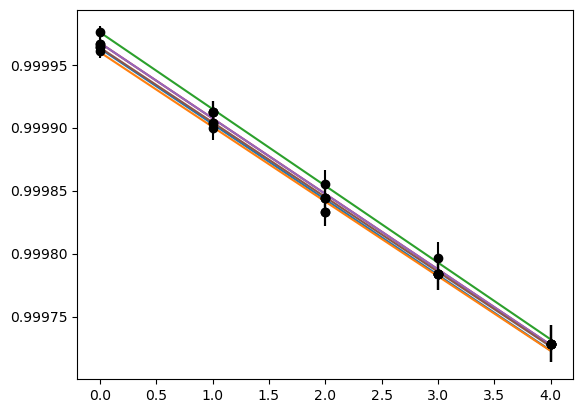

In [47]:
def model(x, N_0, d):
    return N_0*_lambda/(2*d) - x*_lambda/(2*d)

def minimi_quadrati_fit(alfa, beta):
    minimi_quadrati = LeastSquares(x, coseni[alfa:beta], err_coseni[alfa:beta], model)

    m = Minuit(minimi_quadrati, N_0=16600, d=0.0053)

    m.migrad()
    # label every graph obtained by m.visualize()
    m.visualize()

    return m.values["d"], m.errors["d"], m.values["N_0"], m.errors["N_0"]

# calculate weitghed mean of fit_data

d = []
err_d = []
N_0 = []
err_N_0 = []

for i in range(0, 5*6, 5):
    fit_data = minimi_quadrati_fit(i, i+5)
    print(fit_data[0], fit_data[1], fit_data[2], fit_data[3])

    d.append(fit_data[0])
    err_d.append(fit_data[1])
    N_0.append(fit_data[2])
    err_N_0.append(fit_data[3])

# d weighted mean
d = np.array(d)
err_d = np.array(err_d)
N_0 = np.array(N_0)
err_N_0 = np.array(err_N_0)

d_weighted_mean = np.sum(d/err_d**2)/np.sum(1/err_d**2)
err_d_weighted_mean = 1/np.sqrt(np.sum(1/err_d**2))

N_0_weighted_mean = np.sum(N_0/err_N_0**2)/np.sum(1/err_N_0**2)
err_N_0_weighted_mean = 1/np.sqrt(np.sum(1/err_N_0**2))

print("\n", d_weighted_mean, err_d_weighted_mean, N_0_weighted_mean, err_N_0_weighted_mean)

In [30]:
#import pandas as pd

#dati = pd.read_excel("Interferometro.xlsx")
#display(dati)


In [25]:
delta_N = np.array(dati["DeltaN"])

def calcola_delta_d(nome_colonna):
    delta_N = np.array(dati[nome_colonna])

    # Calcola delta_d di ciascun set
    delta_d = []
    sigma_delta_d = []

    # Calcola la media di delta_N di ciascun set
    medie_delta_N = []
    sigma_delta_N = []

    # Calcola la media di ciascun set
    # Abbiamo 3 set di 5 valori
    for i in range(0, 3*5, 5):
        current_set = delta_N[i:i+5]

        media_set = np.mean(current_set)
        medie_delta_N.append(media_set)

        err_set = np.std(current_set) / np.sqrt(len(current_set)) # errore della media!
        sigma_delta_N.append(err_set)
    
    delta_d = np.array(medie_delta_N)*_lambda/2 
    sigma_delta_d = np.array(sigma_delta_N)*_lambda/2

    print(medie_delta_N, sigma_delta_N)

    return delta_d, sigma_delta_d

from scipy.stats import t

# test di ipotesi con t di student
def test_t_student(valore_atteso, valore_calcolato, errore, df, alfa=0.05):
    t_calcolato = np.abs(valore_calcolato - valore_atteso) / errore
    t_critico = t.ppf(1-alfa/2, df)
    print(f"t: {t_calcolato:.3} < t critico: {t_critico:.3} ? {t_calcolato < t_critico} \n")

def stampa_risultati(delta_d, sigma_delta_d, nome_aspettazione, alfa):
    for i in range(len(delta_d)):
        valore_atteso = dati[nome_aspettazione][i*5]*10**(-6)
        errore_micrometro = 0.25*10**(-6)
        valore_calcolato = delta_d[i]
        errore = np.sqrt(sigma_delta_d[i]**2 + errore_micrometro**2)

        print(f"Valore atteso: {valore_atteso:.2e} \nValore calcolato: {valore_calcolato:.2e} +- {errore:.2e} \n")

        test_t_student(valore_atteso, valore_calcolato, errore, 4, alfa)
        
delta_d, err_delta_d = calcola_delta_d("DeltaN")
stampa_risultati(delta_d, err_delta_d, "Deltad eff [microm]", 0.05)

[29.4, 20.4, 14.6] [0.7266360849833979, 0.4560701700396552, 0.35777087639996635]
Valore atteso: 1.00e-05 
Valore calcolato: 9.30e-06 +- 3.40e-07 

t: 2.05 < t critico: 2.78 ? True 

Valore atteso: 7.00e-06 
Valore calcolato: 6.45e-06 +- 2.89e-07 

t: 1.89 < t critico: 2.78 ? True 

Valore atteso: 5.00e-06 
Valore calcolato: 4.62e-06 +- 2.74e-07 

t: 1.39 < t critico: 2.78 ? True 



# Configurazione di Michelson

In [21]:
delta_d, err_delta_d = calcola_delta_d("DeltaN.1")
stampa_risultati(delta_d, err_delta_d, "Deltad eff [microm].1", 0.05)

distanza_lente_schermo = 167.8 * 10**(-2) # metri

# il test è superato con cos(theta) circa 1 come assunzione!

[30.0, 20.4, 15.4] [0.7999999999999999, 0.606630035524124, 0.4560701700396551]
Valore atteso: 1.00e-05 
Valore calcolato: 9.49e-06 +- 3.56e-07 

t: 1.4279032362733286 > t critico: 2.7764451051977987 ? True 

Valore atteso: 7.00e-06 
Valore calcolato: 6.45e-06 +- 3.15e-07 

t: 1.7305521586345969 > t critico: 2.7764451051977987 ? True 

Valore atteso: 5.00e-06 
Valore calcolato: 4.87e-06 +- 2.89e-07 

t: 0.4414933742254073 > t critico: 2.7764451051977987 ? True 

